# DataScience bowl challenge

### Summary
The dataset to be treated in this challenge are cell pictures under very different conditions:
<ul>
    <li>Multiple tissues</li>
    <li>Brightfield microcospy</li>
    <li>Fluorescence microcospy</li>
</ul>
As the technical explanation states the great objective of this competition is to <b>build a very robust model in order to find cell nuclei in the above conditions and more.</b>
<br/>
#### Dataset
The training dataset is composed of 670 images with the above variations and also they come in different dimensions. Label images come in different images each for the manually segmented nuclei.
On the other side the testing dataset is comprised of 65 images.
<br/>
#### Issues found
<ul>
    <li>1. The size of the images is quite different in mamy cases. One solution may be to resize them to the largest or standardize the size</li>
    <li>2. Preprocessing steps will be useless as the conditions are expected to be different</li>
</ul>
<br/>
#### Approaches to deal with this competition
Most of the competitors are going to be using the well know model <b>U-NET</b> another options to try are the following:
<ul>
    <li>Encoder-Decoder</li>
    <li>SqueezNet</li>
    <li>Yolo</li>
</ul>
Finally, it seems more suitable to use <b>Reinforcement Learning Agents with computer vision techniques</b> acting on the input images giving them awards/punish tokens based on each label.
<br/>
#### Some useful scripts to start processing the data
<b><i>Useful packages</i></b>

## Import packages

In [0]:
import os
import sys
import numpy as np
import pandas as pd
import random
import math

from glob import glob
from itertools import chain
#from tqdm import tqdm

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.color import rgb2hsv
from skimage.transform import resize
from skimage.morphology import label, closing, opening, disk

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Parameters

In [0]:
# Set some parameters
NUCLEI_DATADIR = os.path.join(os.getcwd(),'')
PATH_SEPARATOR = os.sep

IMG_CHANNELS = 3
IMG_WIDTH, IMG_HEIGHT = 256, 256

par_seed = 22
#random.seed = par_seed
#np.random.seed = par_seed

par_num_clusters = 3
par_num_clusters = 1

BATCH_SIZE = 16

## Load images info

In [0]:
all_images = glob(os.path.join(NUCLEI_DATADIR, 'stage1_*', '*', '*', '*'))

img_df = pd.DataFrame({'path': all_images})

img_id = lambda in_path: in_path.split(PATH_SEPARATOR)[-3]
img_type = lambda in_path: in_path.split(PATH_SEPARATOR)[-2]
img_group = lambda in_path: in_path.split(PATH_SEPARATOR)[-4].split('_')[1]
img_stage = lambda in_path: in_path.split(PATH_SEPARATOR)[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)

img_df.sample(3)

,path,ImageId,ImageType,TrainingSplit,Stage
11346,C:\Users\Jorge\Desktop\Jorge\uk\aml\nuclei\sta...,5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b9375...,masks,train,stage1
27132,C:\Users\Jorge\Desktop\Jorge\uk\aml\nuclei\sta...,e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f...,masks,train,stage1
17874,C:\Users\Jorge\Desktop\Jorge\uk\aml\nuclei\sta...,958114e5f37d5e1420b410bd716753b3e874b175f2b695...,masks,train,stage1


In [0]:
train_labels = pd.read_csv(os.path.join(NUCLEI_DATADIR,'{}_train_labels.csv'.format(img_df['Stage'][0])))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
28776,f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b...,"[21759, 2, 22013, 4, 22268, 5, 22523, 6, 22778..."
5575,2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48c...,"[204671, 6, 205186, 15, 205703, 22, 206221, 26..."
26535,e49fc2b4f1f39d481a6525225ab3f688be5c87f5688445...,"[39652, 2, 39902, 9, 40158, 9, 40413, 10, 4066..."


## Functions

In [0]:
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0

In [0]:
def image_normalize_chan(chan, ci_ini=0, ci_end=100):
    p_min = np.percentile(chan, ci_ini)
    p_max = np.percentile(chan, ci_end)
    p_avg = np.mean(chan)
    
    chan = (chan - p_min)/(p_max - p_min)    
    chan[chan > 1] = 1
    chan[chan < 0] = 0
    
    return chan

def image_normalize(img, ci_ini=0, ci_end=100):
    out = np.copy(img)
    
    if len(out.shape) == 3:
        for k in range(out.shape[2]):
            out[:,:,k] = image_normalize_chan(out[:,:,k])
    else:
        out = image_normalize_chan(out)
    
    return out

def image_normalize_all(df, ci_ini=0, ci_end=100):
    for i in range(len(df)):
        df['images'].iat[i] = image_normalize(df['images'].iat[i])
    return df

def image_invert_chan(chan):
    if np.mean(chan) > 0.5: chan = 1 - chan
    return chan

def image_invert(img):
    out = np.copy(img)
    
    if len(out.shape) == 3:
        for k in range(out.shape[2]):
            out[:,:,k] = image_invert_chan(out[:,:,k])
    else:
        out = image_invert_chan(out)
    
    return out

def image_3to1chann(img):
    out = np.copy(img)
    out = (out[:,:,0] + out[:,:,1] + out[:,:,2])/3
    return out

def image_1to3chann(img):
    out = np.copy(img)
    out = np.stack((out,out,out),axis=2)
    return out

def image_standarize(img):
    out = np.copy(img)
    out = (out - np.mean(out))/np.power(np.var(out),0.5)
    return out

def image_histogram_equalization(img, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html
    
    image = np.copy(img)
    #image = 256*image

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [0]:
def plot_images(images, images_rows, images_cols):
    print(min(len(images),images_rows*images_cols))
    images_rows = min(images_rows,math.ceil(len(images)/images_cols))
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            k = row*images_cols + col
            if k < len(images):
                image = images[k]
                height, width, l = image.shape
                ax = axarr[row,col]
                ax.axis('off')
                ax.set_title("%dx%d"%(width, height))
                ax.imshow(image)
    plt.show()
    return

## Training

#### Load images

In [0]:
%%time

train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]

train_img_df = pd.DataFrame(train_rows)

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(train_img_df['images'].shape[0], 'train images processed')

train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
print(train_img_df['masks'].shape[0], 'mask images to processed')

train_img_df['nmasks'] = train_img_df['ImageId'].map(lambda x: 
                                                     len(train_df
                                                         .query('ImageId=="'+x+'"')
                                                         .query('ImageType=="masks"')))
train_img_df['shape'] = train_img_df['images'].map(lambda x: x.shape)
train_img_df['pred'] = train_img_df['masks'].copy()

670 train images processed
670 mask images to processed
Wall time: 1min 8s


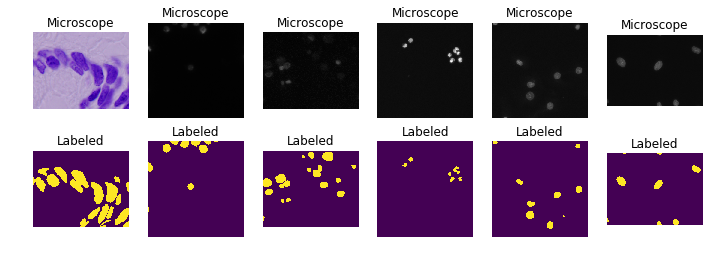

In [0]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')

    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [0]:
#train_img_df = image_normalize_all(train_img_df)

#### K-Means

In [0]:
def kmeans_get_hsv(df):
    hsv_img = []
    hsv_avg = []
    for k in range(len(df)):
        img = rgb2hsv(df['images'].iat[k])
        avg = np.array([np.mean(img[:,:,0]),np.mean(img[:,:,1]),np.mean(img[:,:,2])])
        hsv_img.append(img)
        hsv_avg.append(avg)
    return hsv_img, hsv_avg

def kmeans_get_rgb(df):
    rgb_avg = []
    for k in range(len(df)):
        img = df['images'].iat[k]
        avg = np.array([np.mean(img[:,:,0]),np.mean(img[:,:,1]),np.mean(img[:,:,2])])
        rgb_avg.append(avg)
    return rgb_avg


def kmeans_pre_process(df):
    hsv_img, hsv_avg = kmeans_get_hsv(df)
    df['hsv_img'] = pd.Series(hsv_img)
    df['hsv_avg'] = pd.Series(hsv_avg)
    #df['rgb_avg'] = pd.Series(kmeans_get_rgb(df))
    return df

def kmeans_normalize(df):
    # Normalize images of cluster with most images
    for i in range(len(df)):
        if df['cluster'].iat[i] == 0:
            df['images'].iat[i] = image_normalize(df['images'].iat[i])
    return df

def kmeans_proc(df,kmeans=None):
    if par_num_clusters <= 1:
        df['cluster'] = 0
        return df, None
    
    df = kmeans_pre_process(df)
    
    x = (pd.DataFrame(df['hsv_avg'].values.tolist())).as_matrix()
    #x = (pd.DataFrame(df['rgb_avg'].values.tolist())).as_matrix()
    
    if kmeans is None:
        kmeans = KMeans(n_clusters = par_num_clusters, random_state=22).fit(x)
    
    df['cluster'] = kmeans.predict(x)
    
    return df, kmeans

def kmeans_print_img(df):
    for k in range(par_num_clusters):
        print("Cluster",k,"(",len(df[df['cluster'] == k]['images'].values),")")
        plot_images(df[df['cluster'] == k]['images'].values, 5, 6)

In [0]:
%%time

par_num_clusters = 3

train_img_df, kmeans = kmeans_proc(train_img_df)
train_img_df = kmeans_normalize(train_img_df)

Wall time: 40.5 s


Cluster 0 ( 546 )
30


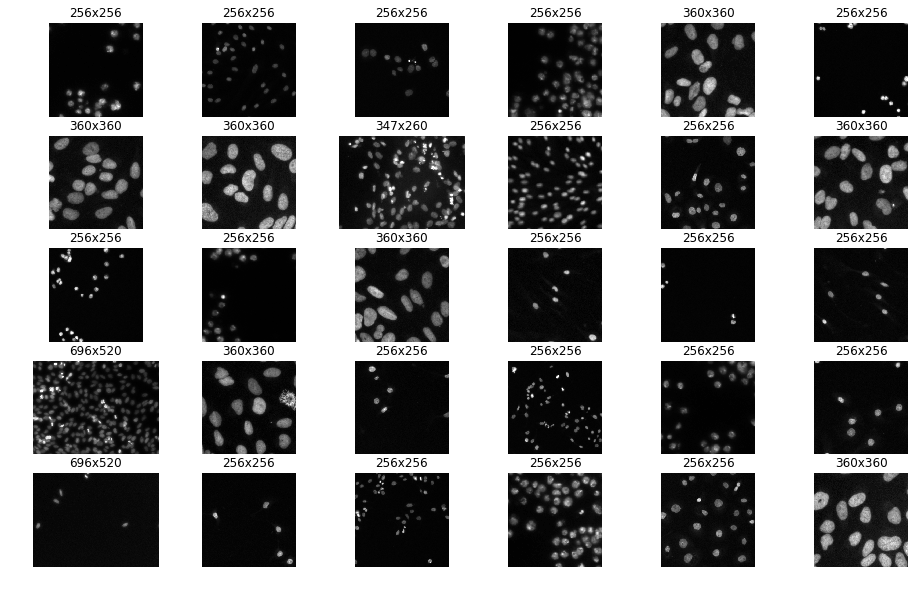

Cluster 1 ( 108 )
30


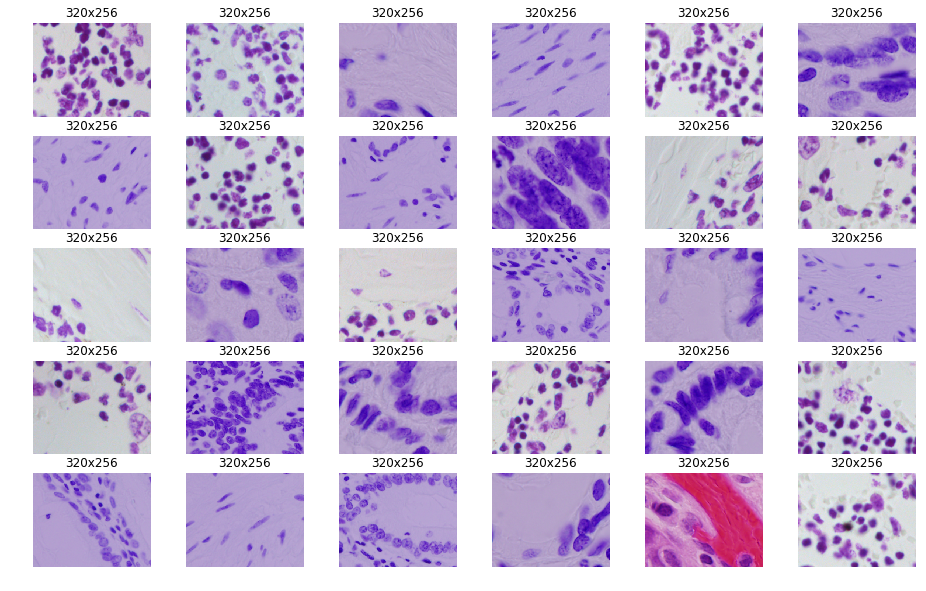

Cluster 2 ( 16 )
16


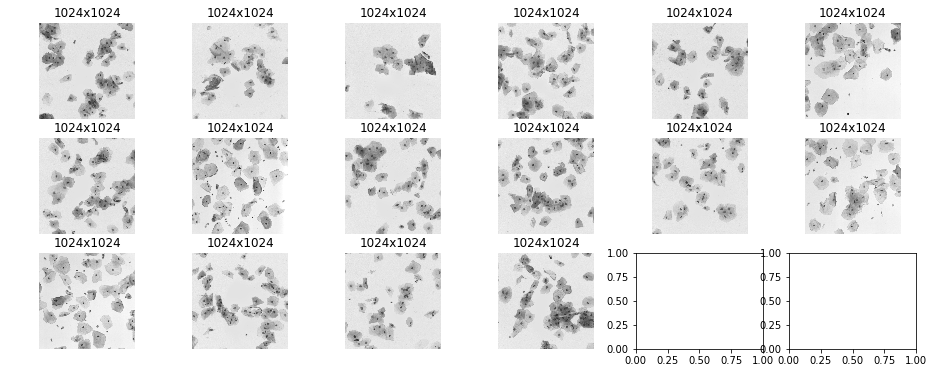

In [0]:
kmeans_print_img(train_img_df)

In [0]:
train_img_df['cluster3'] = train_img_df['cluster'].copy()
train_img_df['cluster'] = train_img_df['cluster'].replace(1, 0)
par_num_clusters = 1

#### Data augmentation

In [0]:
#%%time
if False:
    num_repeats = 1
    #num_repeats = 3
    #num_repeats = 10

    num_head = len(train_img_df)
    #num_head = 10

    train_img_gen_df = train_img_df.head(num_head).copy()
    train_img_gen_df['id'] = np.arange(train_img_gen_df.shape[0])
    train_img_gen_df['iid'] = np.arange(train_img_gen_df.shape[0])
    train_img_gen_df = train_img_gen_df[['id','iid'] + train_img_df.columns.tolist()]

    if num_repeats > 1:
        train_img_val = np.repeat(train_img_gen_df.values, num_repeats, axis=0)

        for i in range(len(train_img_gen_df)):
            if i % 50 == 0: print(i)
            j = 0
            k = num_repeats*i+j
            train_img_val[k][1] = j

            for t in [4,5]:
                img = train_img_val[num_repeats*i][t]

                if t == 4:
                    img = img.reshape((1,) + img.shape)
                else:
                    img = img.reshape((1,) + img.shape + (1,))

                datagen = ImageDataGenerator(fill_mode='wrap',
                                             rotation_range=360,
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             zoom_range=[1/1.3,1.3],
                                             channel_shift_range=0.15#,
                                             #horizontal_flip=True#,
                                             #vertical_flip=True
                                            )

                j = 1
                for batch in datagen.flow(img, batch_size=1, seed=22):
                    k = num_repeats*i+j

                    if t == 4:
                        train_img_val[k][t] = batch[0]
                    else:
                        train_img_val[k][t] = batch[0].reshape(batch[0].shape[:2])

                    train_img_val[k][1] = j
                    j += 1
                    if j == num_repeats: break
                del datagen

        train_img_gen_df = pd.DataFrame(data=train_img_val,columns=train_img_gen_df.columns.tolist())
        del train_img_val

In [0]:
if False:
    num_img = 5

    fig = plt.figure(figsize = (20, 2*num_repeats+2))

    for i in range(num_repeats):
        for j in range(num_img):
            k = j*num_repeats + i
            p = 2*(i*num_img + j) + 1

            ax = fig.add_subplot(num_repeats, 2*num_img, p)
            ax.imshow(train_img_gen_df['images'][k])
            ax = fig.add_subplot(num_repeats, 2*num_img, p+1)
            ax.imshow(train_img_gen_df['masks'][k])

    plt.show()

## Training

#### Own metrics

In [0]:
# IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Dice coeficient
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### U-Net model

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

[this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation)

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
def model_create():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    return Model(inputs=[inputs], outputs=[outputs])

def model_fit(k, X, Y, mode=0, len_train=0):
    if k >= par_num_clusters: return
    
    model = model_create()
    
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    #model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=[mean_iou])
    model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=[dice_coef,mean_iou])
    
    #model.summary()
    
    # Configure iterations
    earlystopper = EarlyStopping(monitor='val_loss', mode='min',
                                 #monitor='dice_coef', mode='max',
                                 patience=10,
                                 verbose=1)

    checkpointer_1 = ModelCheckpoint('dsbowl2018_'+str(k)+'_1.h5',
                                     monitor='val_loss', mode='min',
                                     verbose=1,
                                     save_best_only=True)

    checkpointer_2 = ModelCheckpoint('dsbowl2018_'+str(k)+'_2.h5',
                                     monitor='dice_coef', mode='max',
                                     verbose=1,
                                     save_best_only=True)

    checkpointer_3 = ModelCheckpoint('dsbowl2018_'+str(k)+'_3.h5',
                                     monitor='mean_iou', mode='max',
                                     verbose=1,
                                     save_best_only=True)
    
    # Model parameters
    model_params = {}
    model_params['callbacks'] = [earlystopper, checkpointer_1, checkpointer_2, checkpointer_3]
    model_params['epochs'] = 200
    
    if mode == 0:
        len_train = len(X)
    
    # Model learning rate decay: exponential
    exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
    steps = int(len_train/BATCH_SIZE)*7 * 100
    lr_init, lr_fin = 0.001, 0.0001
    lr_decay = exp_decay(lr_init, lr_fin, steps)
    K.set_value(model.optimizer.lr, lr_init)
    K.set_value(model.optimizer.decay, lr_decay)
    
    # Model fit
    if mode == 0:
        results = model.fit(X, Y,
                            validation_split=0.1,
                            batch_size = BATCH_SIZE,
                            **model_params)
    else:
        results = model.fit_generator(X,
                                      validation_data=Y,
                                      validation_steps=10,
                                      steps_per_epoch=100,#250,
                                      **model_params)

    print()
    print()
    return results

#### Prepare data

In [0]:
%%time

def get_xy(df):
    num_samples = df['images'].shape[0]
    
    images = np.zeros((num_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.dtype(float))
    labels = np.zeros((num_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    #for i, c_row in df.iterrows():
    i = 0
    for j, c_row in df.iterrows():
        images[i] = resize(c_row['images'], 
                           (IMG_HEIGHT, IMG_WIDTH), 
                           mode='constant', 
                           preserve_range=True)

        labels[i] = np.expand_dims(resize(c_row['masks'], 
                                          (IMG_HEIGHT, IMG_WIDTH), 
                                          mode='constant', 
                                          preserve_range=True), axis=-1)
        
        i+=1
    
    return images, labels

images_k = []
labels_k = []

for k in range(par_num_clusters):
    images, labels = get_xy(train_img_df[train_img_df['cluster'] == k])
    images_k.append(images)
    labels_k.append(labels)

Wall time: 13.9 s


In [0]:
%%time

datagen_dict = {}
datagen_dict['shear_range']        = 0.5
datagen_dict['rotation_range']     = 50
datagen_dict['zoom_range']         = 0.2
datagen_dict['width_shift_range']  = 0.2
datagen_dict['height_shift_range'] = 0.2
datagen_dict['fill_mode']          = 'reflect'

def create_datagen(img,train_split,is_train):
    if is_train:
        datagen = ImageDataGenerator(**datagen_dict)
    else:
        datagen = ImageDataGenerator()
    
    ini = 0
    fin = img.shape[0]
    
    if is_train: fin = int(train_split*fin)
    else:        ini = int(train_split*fin)
    
    datagen.fit(img[ini:fin], augment=True, seed=42)

    return datagen.flow(img[ini:fin],
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=par_seed)

img_datagen_t_k = []
lbl_datagen_t_k = []
img_datagen_v_k = []
lbl_datagen_v_k = []
for k in range(par_num_clusters):
    img_datagen_t_k.append(create_datagen(images_k[k], 0.9, True))
    lbl_datagen_t_k.append(create_datagen(labels_k[k], 0.9, True))
    img_datagen_v_k.append(create_datagen(images_k[k], 0.9, False))
    lbl_datagen_v_k.append(create_datagen(labels_k[k], 0.9, False))

Wall time: 11.5 s


In [0]:
if False:
    k = 0

    imshow(img_datagen_t_k[k].next()[0])
    plt.show()
    imshow(np.squeeze(lbl_datagen_t_k[k].next()[0]))
    plt.show()
    imshow(img_datagen_v_k[k].next()[0])
    plt.show()
    imshow(np.squeeze(lbl_datagen_v_k[k].next()[0]))
    plt.show()

#### Training

In [0]:
%%time

k = 0
#model_fit(k, images_k[k], labels_k[k])
model_fit(k, zip(img_datagen_t_k[k],lbl_datagen_t_k[k]), zip(img_datagen_v_k[k],lbl_datagen_v_k[k]), 1, len(images_k[k]))

Epoch 1/200
 99/100 [============================>.] - ETA: 0s - loss: 0.4768 - dice_coef: 0.2917 - mean_iou: 0.4175
Epoch 00001: val_loss improved from inf to 0.20974, saving model to dsbowl2018_0_1.h5

Epoch 00001: dice_coef improved from -inf to 0.29388, saving model to dsbowl2018_0_2.h5

Epoch 00001: mean_iou improved from -inf to 0.41751, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 67s 675ms/step - loss: 0.4739 - dice_coef: 0.2938 - mean_iou: 0.4175 - val_loss: 0.2097 - val_dice_coef: 0.5121 - val_mean_iou: 0.4280
Epoch 2/200
 99/100 [============================>.] - ETA: 0s - loss: 0.2357 - dice_coef: 0.5295 - mean_iou: 0.4510
Epoch 00002: val_loss improved from 0.20974 to 0.16007, saving model to dsbowl2018_0_1.h5

Epoch 00002: dice_coef improved from 0.29388 to 0.53049, saving model to dsbowl2018_0_2.h5

Epoch 00002: mean_iou improved from 0.41751 to 0.45128, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 60s 604ms

Epoch 16/200
 99/100 [============================>.] - ETA: 0s - loss: 0.0764 - dice_coef: 0.8578 - mean_iou: 0.7731
Epoch 00016: val_loss did not improve

Epoch 00016: dice_coef improved from 0.85670 to 0.85764, saving model to dsbowl2018_0_2.h5

Epoch 00016: mean_iou improved from 0.76751 to 0.77312, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 59s 595ms/step - loss: 0.0769 - dice_coef: 0.8576 - mean_iou: 0.7731 - val_loss: 0.0806 - val_dice_coef: 0.8363 - val_mean_iou: 0.7758
Epoch 17/200
 99/100 [============================>.] - ETA: 0s - loss: 0.0717 - dice_coef: 0.8639 - mean_iou: 0.7784
Epoch 00017: val_loss improved from 0.07476 to 0.07385, saving model to dsbowl2018_0_1.h5

Epoch 00017: dice_coef improved from 0.85764 to 0.86409, saving model to dsbowl2018_0_2.h5

Epoch 00017: mean_iou improved from 0.77312 to 0.77840, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 59s 595ms/step - loss: 0.0718 - dice_coef: 0.8640

 99/100 [============================>.] - ETA: 0s - loss: 0.0656 - dice_coef: 0.8732 - mean_iou: 0.8204
Epoch 00032: val_loss improved from 0.06440 to 0.06308, saving model to dsbowl2018_0_1.h5

Epoch 00032: dice_coef did not improve

Epoch 00032: mean_iou improved from 0.81882 to 0.82044, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 59s 593ms/step - loss: 0.0655 - dice_coef: 0.8729 - mean_iou: 0.8204 - val_loss: 0.0631 - val_dice_coef: 0.8628 - val_mean_iou: 0.8213
Epoch 33/200
 99/100 [============================>.] - ETA: 0s - loss: 0.0670 - dice_coef: 0.8745 - mean_iou: 0.8221
Epoch 00033: val_loss did not improve

Epoch 00033: dice_coef improved from 0.87470 to 0.87490, saving model to dsbowl2018_0_2.h5

Epoch 00033: mean_iou improved from 0.82044 to 0.82210, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 59s 589ms/step - loss: 0.0669 - dice_coef: 0.8745 - mean_iou: 0.8221 - val_loss: 0.0634 - val_dice_coef: 0.8606 - 

Epoch 49/200
 99/100 [============================>.] - ETA: 0s - loss: 0.0613 - dice_coef: 0.8819 - mean_iou: 0.8403
Epoch 00049: val_loss did not improve

Epoch 00049: dice_coef did not improve

Epoch 00049: mean_iou improved from 0.83947 to 0.84029, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 59s 591ms/step - loss: 0.0612 - dice_coef: 0.8820 - mean_iou: 0.8403 - val_loss: 0.0596 - val_dice_coef: 0.8754 - val_mean_iou: 0.8407
Epoch 50/200
 99/100 [============================>.] - ETA: 0s - loss: 0.0603 - dice_coef: 0.8852 - mean_iou: 0.8411
Epoch 00050: val_loss did not improve

Epoch 00050: dice_coef improved from 0.88469 to 0.88522, saving model to dsbowl2018_0_2.h5

Epoch 00050: mean_iou improved from 0.84029 to 0.84114, saving model to dsbowl2018_0_3.h5
100/100 [==============================] - 59s 591ms/step - loss: 0.0602 - dice_coef: 0.8854 - mean_iou: 0.8411 - val_loss: 0.0628 - val_dice_coef: 0.8648 - val_mean_iou: 0.8416
Epoch 51/200
 99/1

## Predict

#### Load test images

In [0]:
%%time

test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]

test_img_df = pd.DataFrame(test_rows)
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'test images processed')
test_img_df.sample(1)

65 test images processed
Wall time: 962 ms


In [0]:
test_img_df = image_normalize_all(test_img_df)

#### Predict

In [0]:
test_img_df['shape'] = test_img_df['images'].map(lambda x: x.shape)
test_img_df['pred'] = test_img_df['images'].copy()
test_img_df, kmeans = kmeans_proc(test_img_df, kmeans)

In [0]:
if False:
    for i in range(len(test_img_df)):
        if test_img_df['ImageId'].iat[i] == '3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26':
            test_img_df['cluster'].iat[i] = 2

Cluster 0 ( 65 )
30


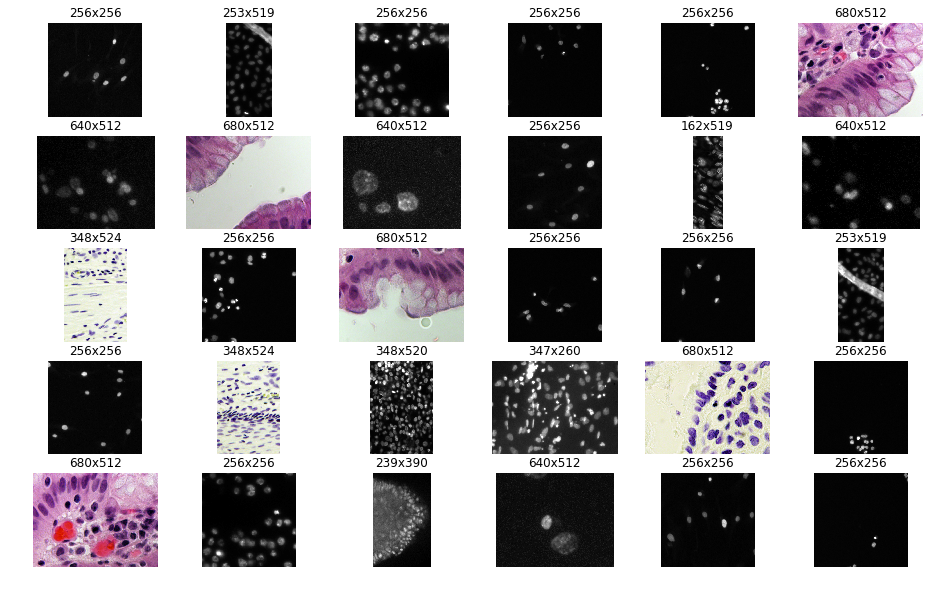

In [0]:
kmeans_print_img(test_img_df)

In [0]:
%%time

def predict(model,k,df):
    for i, c_row in df[df['cluster'] == k].iterrows():
        pred = model.predict(np.expand_dims(resize(c_row['images'],
                                                   (IMG_HEIGHT, IMG_WIDTH), 
                                                   mode='constant', 
                                                   preserve_range=True), 0))
        df.at[i, 'pred'] = pred
    return df

for k in range(par_num_clusters):
    print("Predicting cluster",k)
    
    model_file = 'dsbowl2018_'+str(k)+'_1.h5' #val_loss
    #model_file = 'dsbowl2018_'+str(k)+'_2.h5' #dice_coef
    #model_file = 'dsbowl2018_'+str(k)+'_3.h5' #mean_iou
    
    model = load_model(model_file, custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef})
    
    print("  ","train")
    predict(model,k,train_img_df)
    
    print("  ","test")
    predict(model,k,test_img_df)

Predicting cluster 0
   train
   test
Wall time: 27.8 s


## Generate submission file

#### Support functions

In [0]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

#### Check RLE function

In [0]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


#### Create submission file

In [0]:
rles = []
for _, d_row in test_img_df.iterrows():
    pred_mask = np.squeeze(d_row['pred'])
    resized_mask = resize(pred_mask, (d_row['shape'][0], d_row['shape'][1]), mode='constant', preserve_range=True)
    rles.append(prob_to_rles(resize(resized_mask, (d_row['shape'][0], d_row['shape'][1]), mode='constant', preserve_range=True)))

test_img_df = test_img_df.assign(rles=pd.Series(rles).values)

out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)

2590 regions found for 65 images


# STOP

#### Show some predictions

In [0]:
def print_train_pred(img_ini=0,img_end=5):
    n_img = img_end - img_ini

    fig, m_axs = plt.subplots(n_img, 4, figsize = (20, n_img*5))
    #for (_, d_row), (c_img, c_msk, c_prd, c_cln) in zip(train_img_df.head(n_img).iterrows(), m_axs):
    for (_, d_row), (c_img, c_msk, c_prd, c_cln) in zip(train_img_df[img_ini:img_end].iterrows(), m_axs):
        print(d_row['ImageId'])

        c_img.set_title('Image')
        c_img.axis('off')
        c_img.imshow(d_row['images'])

        c_msk.set_title('Mask ({:d})'.format(d_row['nmasks']))
        c_msk.axis('off')
        c_msk.imshow(d_row['masks'])

        c_prd.set_title('Predicted')
        c_prd.axis('off')
        pred_mask = np.squeeze(d_row['pred'])
        resized_mask = resize(pred_mask, (d_row['shape'][0], d_row['shape'][1]), mode='constant', preserve_range=True)
        c_prd.imshow(resized_mask)

        c_cln.set_title('Clean')
        c_cln.axis('off')
        clean_mask = clean_img(resized_mask)
        c_cln.imshow(clean_mask)

        new_mask = np.ma.masked_where(clean_mask == 0, clean_mask)
        #c_cln.imshow(clean_mask, cmap='Paired')
        #c_cln.imshow(new_mask, cmap='prism', interpolation='none')
        #c_cln.set_title('Clean ({:d})'.format(np.max(new_mask)))
    plt.show()
    return

In [0]:
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.feature import peak_local_max, canny

def clean_img(x, cut_off = 0.1):
    clean = opening(closing(x, disk(1)), disk(3))
    
    #clean = canny(clean, sigma=1.5)
    
    raw_bodies
    
    
    clean[np.where(clean < 0.45)]=0
    clean[np.where(clean > 0.75)]=0
    
    raw_bodies - k * raw_edges > threshold
    
    #clean = label(clean > 0.7, connectivity=1)
    
    #clean = 1*(clean > cut_off)
    
    #distance = ndi.distance_transform_edt(clean)
    #local_maxi = peak_local_max(distance, indices=False, labels=clean, footprint=np.ones((10, 10)))
    #markers = ndi.label(local_maxi)[0]
    #clean = watershed(-distance, markers, mask=clean)
    
    return clean

In [0]:
def plot_images(img, tit, images_rows, images_cols):
    images_rows = math.min(images_rows,math.ceil(len(img)/images_cols))
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*4))
    for row in range(images_rows):
        for col in range(images_cols):
            k = row*images_cols + col
            if k < len(img):
                image = img[k]
                ax = axarr[row,col]
                ax.axis('off')
                ax.set_title(tit[k])
                ax.imshow(image)
    plt.show()
    return

def print_train_pred_2(img_ini=0,img_end=5):
    for k in range(img_ini,img_end):
        print(train_img_df['ImageId'].iat[k])
        
        img = []
        tit = []
        
        tit.append("Image")
        img.append(train_img_df['images'].iat[k])
        
        tit.append('Mask ({:d})'.format(train_img_df['nmasks'].iat[k]))
        img.append(train_img_df['masks'].iat[k])
        
        tit.append("Pred")
        pred_mask = np.squeeze(train_img_df['pred'].iat[k])
        resized_mask = resize(pred_mask,
                              (train_img_df['shape'].iat[k][0], train_img_df['shape'].iat[k][1]),
                              mode='constant',
                              preserve_range=True)
        img.append(resized_mask)
        
        
        clean = opening(closing(resized_mask, disk(1)), disk(3))
        
        raw_bodies = np.copy(clean)
        raw_bodies[np.where(raw_bodies < 0.50)]=0
        
        raw_edges = np.copy(clean)
        raw_edges[np.where(raw_edges < 0.20)] = 0
        raw_edges[np.where(raw_edges > 0.80)] = 0
        
        bodies = 1*(raw_bodies > 0)
        edges = 1*(raw_edges > 0)
        
        labels_ = raw_bodies - 2 * raw_edges > 0.25
        
        labels = bodies - edges
        labels[np.where(labels < 0)] = 0
        
        distance = ndi.distance_transform_edt(labels)
        local_maxi = peak_local_max(distance, indices=False, labels=labels, footprint=np.ones((10, 10)))
        markers = ndi.label(local_maxi)[0]
        final_labels = watershed(-distance, markers, mask=bodies)
        
        #final_labels = watershed(-ndi.distance_transform_edt(bodies), labels, mask=bodies)
        
        tit.append("Clean")
        img.append(clean)
        
        tit.append("Raw bodies")
        img.append(raw_bodies)
        
        tit.append("Bodies")
        img.append(bodies)
        
        tit.append("Raw edges")
        img.append(raw_edges)
        
        tit.append("Edges")
        img.append(edges)
        
        tit.append("Labels*")
        img.append(labels_)
        
        tit.append("Labels")
        img.append(labels)
        
        tit.append("Markers")
        img.append(markers)
        
        tit.append("Final Labels ({:d})".format(np.max(final_labels)))
        img.append(final_labels)
        
        plot_images(img,tit,3,4)
        
        new_mask = np.ma.masked_where(final_labels == 0, final_labels)
        plt.imshow(final_labels, cmap='Paired')
        plt.imshow(new_mask, cmap='prism', interpolation='none')
        plt.show()
    return

#print_train_pred_2(58,59)
print_train_pred_2(4,5)

# TESTING

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2, x3, y3 = 28, 28, 44, 52, 60, 60
r1, r2, r3 = 16, 20, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
mask_circle3 = (x - x3)**2 + (y - y3)**2 < r3**2
image = np.logical_or(mask_circle1, mask_circle2)
image = np.logical_or(image, mask_circle3)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((1, 1)),
                            labels=image)
markers = ndi.label(local_maxi, structure=ndi.morphology.generate_binary_structure(2,2))[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
#ax[0].imshow(local_maxi, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(markers, interpolation='nearest')
#ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()